# 平坦事前分布の下でのベイズ版ABテストはP値版ABテストとほぼ同等である

* 黒木玄
* 2024-10-20

In [1]:
using Distributions
using Roots
using StatsPlots
default(fmt=:png, titlefontsize=10)

ecdf_(A, x) = count(≤(x), A) / length(A)
safemul(x, y) = x == 0 ? zero(x*y) : y == 0 ? zero(x*y) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(x/y) : x/y
r(x) = round(x; sigdigits=3)

r (generic function with 1 method)

## リスク差に関するスコア法のP値の実装

In [2]:
### score method for risk difference

riskdiffhat_score(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function loglik_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safemul(a, log(p)) + safemul(b, log(1-p)) + safemul(c, log(q)) + safemul(d, log(1-q))
end

function scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p) + safediv(c, q) - safediv(d, 1-q)
end

function d_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    -safediv(a, p^2) - safediv(b, (1-p)^2) - safediv(c, q^2) - safediv(d, (1-q)^2)
end

function scorestat_Δ_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p)
end

function estimate_q_given_Δ_rd(a, b, c, d, Δ=0.0; alg=Bisection())
    qmin, qmax = max(0.0, -Δ), min(1.0, 1.0-Δ)
    a+c==0 && return qmin
    b+d==0 && return qmax
    f(q) = scorestat_q_rd(a, b, c, d, q, Δ)
    S_qmin = f(qmin + eps())
    S_qmax = f(qmax - eps())
    S_qmin ≥ 0 && S_qmax ≥ 0 && return S_qmin < S_qmax ? qmin : qmax
    S_qmin ≤ 0 && S_qmax ≤ 0 && return S_qmin < S_qmax ? qmax : qmin
    find_zero(f, (qmin + eps(), qmax - eps()), alg)
end

function varinv_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(p*(1-p), a+b) + safediv(q*(1-q), c+d)
end

function chisqstat_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    Δ = clamp(Δ, -1 + eps(), 1 - eps())
    q̃ = estimate_q_given_Δ_rd(a, b, c, d, Δ; alg)
    S = scorestat_Δ_rd(a, b, c, d, q̃, Δ)
    Vinv = varinv_scorestat_q_rd(a, b, c, d, q̃, Δ)
    safemul(S^2, Vinv)
end

function pvalue_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    χ² = chisqstat_rd_score(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

function confint_rd_score(a, b, c, d; α=0.05, alg=Bisection())
    χ²_α = cquantile(Chisq(1), α)
    RDhat = riskdiffhat_score(a, b, c, d)
    g(Δ) = chisqstat_rd_score(a, b, c, d; Δ, alg) - χ²_α
    L = if g(-1 + eps()) > 0
        find_zero(g, (-1 + eps(), RDhat), alg)
    else
        -1.0
    end
    U = if g(1 - eps()) > 0
        find_zero(g, (RDhat, 1 - eps()), alg)
    else
        1.0
    end
    [L, U]
end

function zstat_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    χ² = chisqstat_rd_score(a, b, c, d; Δ, alg)
    sign(riskdiffhat_score(a, b, c, d) - Δ) * √χ²
end

function pvalue_rd_score_onesided(a, b, c, d; Δ=0.0, alg=Bisection())
    z = zstat_rd_score(a, b, c, d; Δ, alg)
    ccdf(Normal(), z)
end

pvalue_rd_score_onesided (generic function with 1 method)

## 事後確率とP値の同時プロットの関数

In [3]:
function plot_AB_test(a, b, c, d; prior_params=(1, 1),
        plim=(-0.02, 1.02), ptick=0:0.1:1, xlim=(-1.0, 1.0), xtick=-1:0.2:1, L=10^7)
    posteriorA = Beta((prior_params .+ (a, b))...)
    posteriorB = Beta((prior_params .+ (c, d))...)
    pA = rand(posteriorA, L)
    pB = rand(posteriorB, L)
    pAmpB = pA .- pB

    P = density(pA; label="posterior density of p_A")
    density!(pB; label="posterior density of p_B")
    plot!(; xlim=plim, xtick=ptick)
    plot!(xguide="p_A, p_B")
    title!("data: [$a $b; $c $d],  prior: Beta$prior_params")
    plot!(bottommargin=4Plots.mm)

    Q = density(pAmpB; label="", c=3)
    vline!([0]; label="", c=:black, lw=0.5)
    plot!(; xlim, xtick)
    plot!(xguide="Δ")
    title!("posterior probability density of p_A - p_B = Δ")

    R = plot(Δ -> ecdf_(pAmpB, Δ), -1, 1;
        label="posterior probability", c=3)
    plot!(Δ -> pvalue_rd_score_onesided(a, b, c, d; Δ);
        label="one-sided P-value", c=4, ls=:dash)
    vline!([0]; label="", c=:black, lw=0.5)
    plot!(; xlim, xtick)
    plot!(ytick=0:0.05:1)
    plot!(xguide="Δ")
    plot!(legend=:bottomright)
    title!("posterior probability and one-sided P-value of p_A - p_B ≤ Δ")

    S = plot(Δ -> pvalue_rd_score(a, b, c, d; Δ), -1, 1;
        label="", c=4, ls=:dash)
    vline!([0]; label="", c=:black, lw=0.5)
    plot!(; xlim, xtick)
    plot!(ytick=0:0.05:1)
    plot!(xguide="Δ")
    title!("two-sided P-value of p_A - p_B = Δ")

    plot(P, Q, R, S; size=(1024, 720), layout=(2, 2))
end

plot_AB_test (generic function with 1 method)

## 例1

>ベイジアンABテストってありなの? / Is Bayesian AB Testing Truly Effective?<br>
>ABテストの課題あるあるに対するアプローチとしてよく登場するベイジアンABテストについて、その有用性に関する理解をゆるふわに説明します。<br>
>DeNA+GO社内勉強会/AI技術共有会 2024-05-15発表<br>
>ak_iyama<br>
>June 26, 2024

https://speakerdeck.com/ak_iyama/b-testing-truly-effective

<img src="IMG_6697.jpeg" width=640>

上のスクリーンショット中の右下のグラフは以下のグラフ中の左上隅で再現されている.

以下のグラフ中では A, B のconversion ratesの差を p_A, p_B と書いている.

以下のグラフ中の左下隅では

* 事後分布における p_A − p_B ≤ Δ となる確率(事後確率)
* 検定仮説 p_A − p_B ≤ Δ の片側P値

を比較するために同時プロットしている.  それらは近似的に一致している.

事後確率とそれに適切に対応するP値の近似的な一致は数学的必然であり, 一般的に証明可能である.

以下のグラフ中の右上隅と右下隅はそれぞれ

* 事後分布における p_A − p_B = Δ となる確率の密度
* 検定仮説 p_A − p_B = Δ の両側P値

のグラフである.  それらを比較すると, それらはほぼ同じ使い方をできる道具であることがわかる.

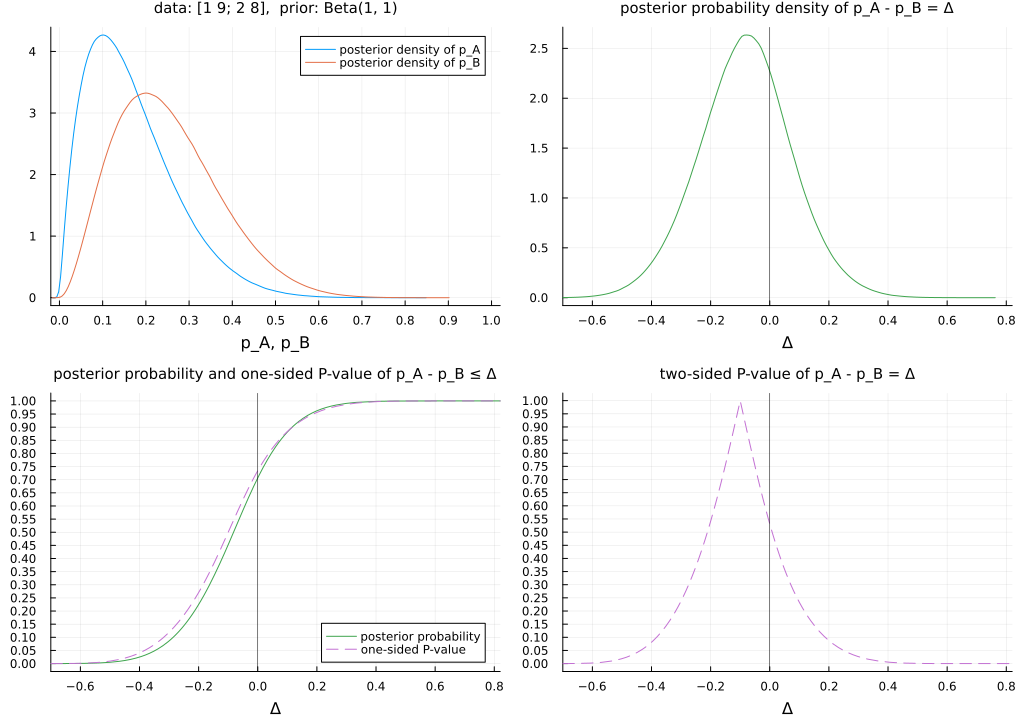

In [4]:
plot_AB_test(1, 9, 2, 8; xlim=(-0.7, 0.82))

https://speakerdeck.com/ak_iyama/b-testing-truly-effective

<img src="IMG_6698.jpeg" width=640>

以下のグラフ中の左下隅は, 上の方と同様に, 

* 事後分布における p_A − p_B ≤ Δ となる確率(事後確率)
* 検定仮説 p_A − p_B ≤ Δ の片側P値

の同時プロットである. それらの近似的一致の誤差は非常に小さくなっており, それらのグラフはほぼぴったり重なっている.

事後確率とP値の定義は完全に異なる.

しかし, 数学の解析学には「定義が異なる2つの量が適切な条件の下で近似的に一致する」の形の定理が無数にあり, 確率論はそのような定理達の宝庫である.  事後確率とP値の近似的一致もそのような定理の1つである.

事後確率はそれに適切に対応するP値に近似的に一致する.

ゆえに, 事後確率が高いという理由で「Bの方がAよりも優れている」と判断することは, P値が高いという理由で「Bの方がAよりも優れている」と判断することと実践的には同じことになる.

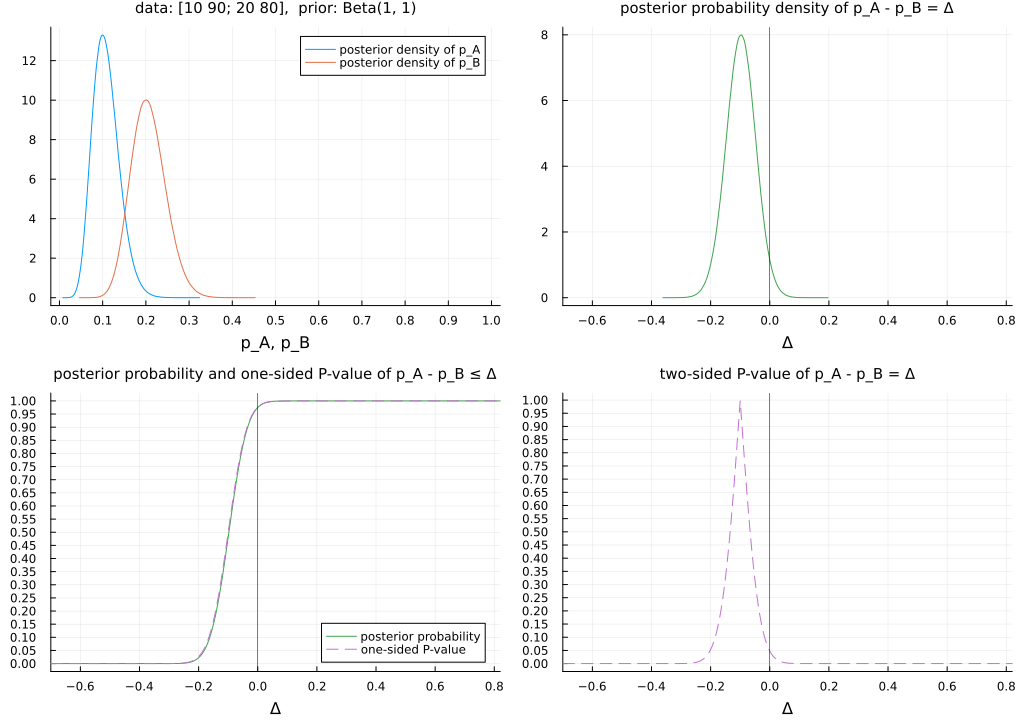

In [5]:
plot_AB_test(10, 90, 20, 80; xlim=(-0.7, 0.82))

https://speakerdeck.com/ak_iyama/b-testing-truly-effective

<img src="IMG_6699.jpeg" width=640>

<img src="IMG_6700.jpeg" width=640>

以上の引用中では「まだよくわからない。。。」と述べられているが, 実践的な状況において事後確率とP値がよく一致することを知っていれば, 正解が何であるかは明らかである.

事後確率が都合の良いものになるまでデータの取得を続けることは, P-hackingと実践的には同じことをしていることになる.

P値についてやってはいけないことは, ベイズ統計における事後分布においてもやってはいけない. これが正しい考え方である.

非常に残念なことに, 事後確率が近似的にP値に一致するというコンピュータを使えば誰でも容易に確認できる事実を知らない人が, 「頻度主義 vs. ベイズ主義」という不適切な対立図式を描いて, ベイズ統計について不適切な解説をしていることがよくある.  騙されないように注意した方あよい.

## 例2

>@perico_v1<br>
>RとStanでBayes A/Bテスト<br>
>ABテスト<br>
>投稿日 2021年03月16日

https://qiita.com/perico_v1/items/6f46773063458637e7ca

<img src="IMG_6701.jpeg" width=640>

<img src="IMG_6707.jpeg" width=640>

以上の設定でも, 以下の左下隅を見れば, 事後確率とP値がよく一致している.

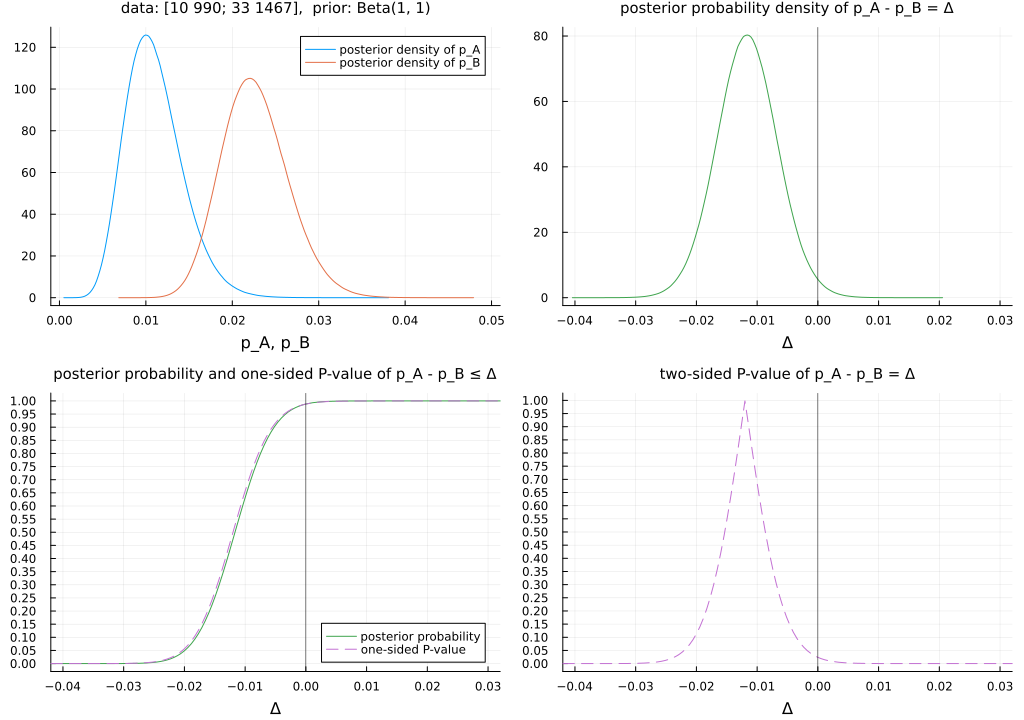

In [6]:
plot_AB_test(10, 990, 33, 1467;
    plim=(-0.001, 0.051), ptick=0:0.01:1, xlim=(-0.042, 0.032), xtick=-1:0.01:1)

## 例3-1

>RでベイジアンABテストやってみた。<br>
>mochizuki<br>
>2021.03.29

https://gri.jp/media/entry/398

<img src="IMG_6702.jpeg" width=640>

以上の設定でも, 以下の左下隅を見れば, 事後確率とP値がよく一致している.

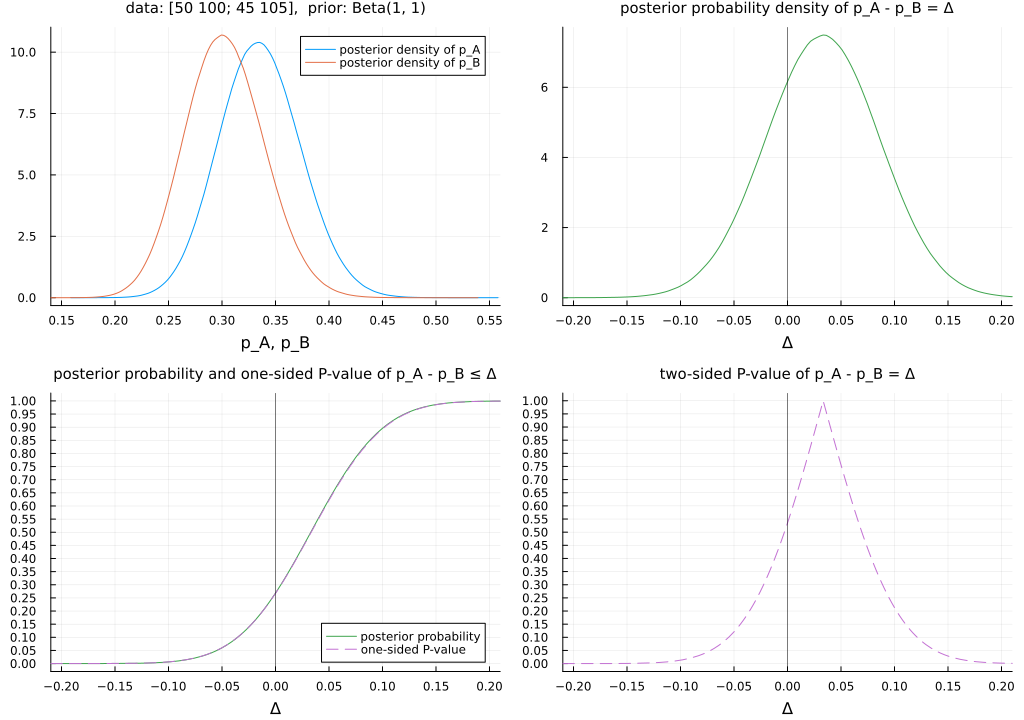

In [7]:
plot_AB_test(50, 100, 45, 105;
    plim=(0.14, 0.56), ptick=0:0.05:1, xlim=(-0.21, 0.21), xtick=-1:0.05:1)

## 例3-2

>ベイジアンABテストにおける事前分布のパラメータ設定<br>
>mochizuki<br>
>2021.06.03

https://gri.jp/media/entry/371

<!-- <img src="IMG_6703.jpeg" width=640> -->

データの数値は $[85 \ 115;\ 80 \ 120]$.

以下のグラフはそれぞれ事前分布が Beta(1, 1), Beta(2, 3), Beta(20, 30) の場合.

しかし, おそらく, すぐ下の Beta(1, 1) の場合のグラフ例3-1のグラフと同じなので間違っている.

<img src="IMG_6704.jpeg" width=640>

<img src="IMG_6706.jpeg" width=640>

以下のグラフの各々の左下隅を見れば分かるように, 事前分布が Beta(1, 1), Beta(2, 3) の場合には事後確率と片側P値はほぼいったり一致しており, Beta(20, 30) の場合にはずれが生じているがまだ近似的には一致している.

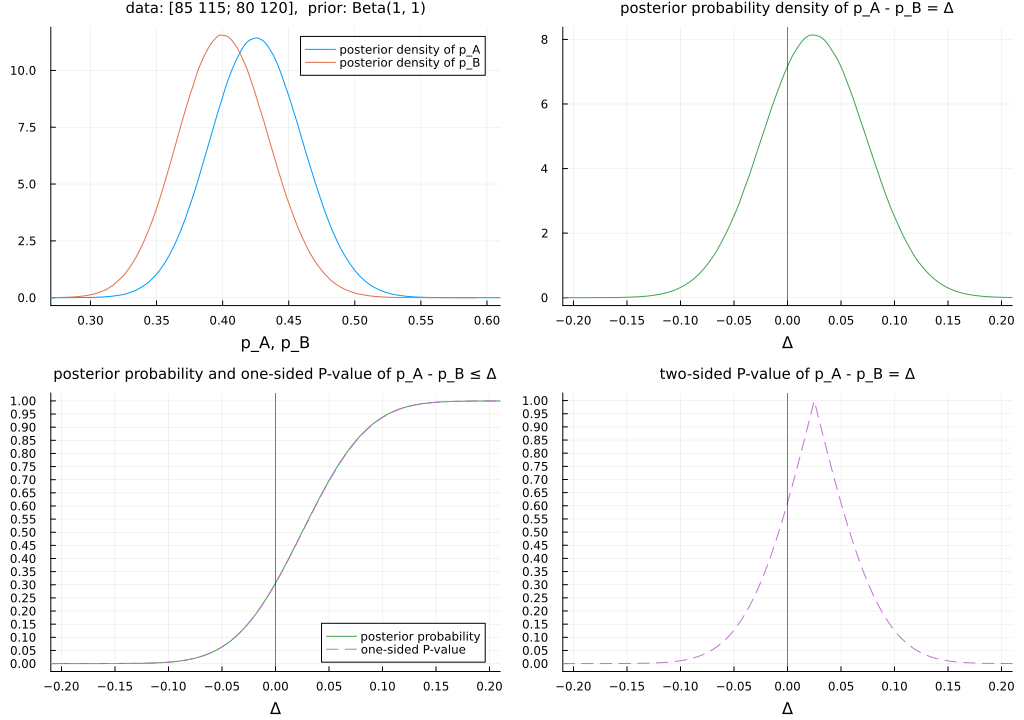

In [8]:
plot_AB_test(85, 115, 80, 120; prior_params=(1, 1),
    plim=(0.27, 0.61), ptick=0:0.05:1, xlim=(-0.21, 0.21), xtick=-1:0.05:1)

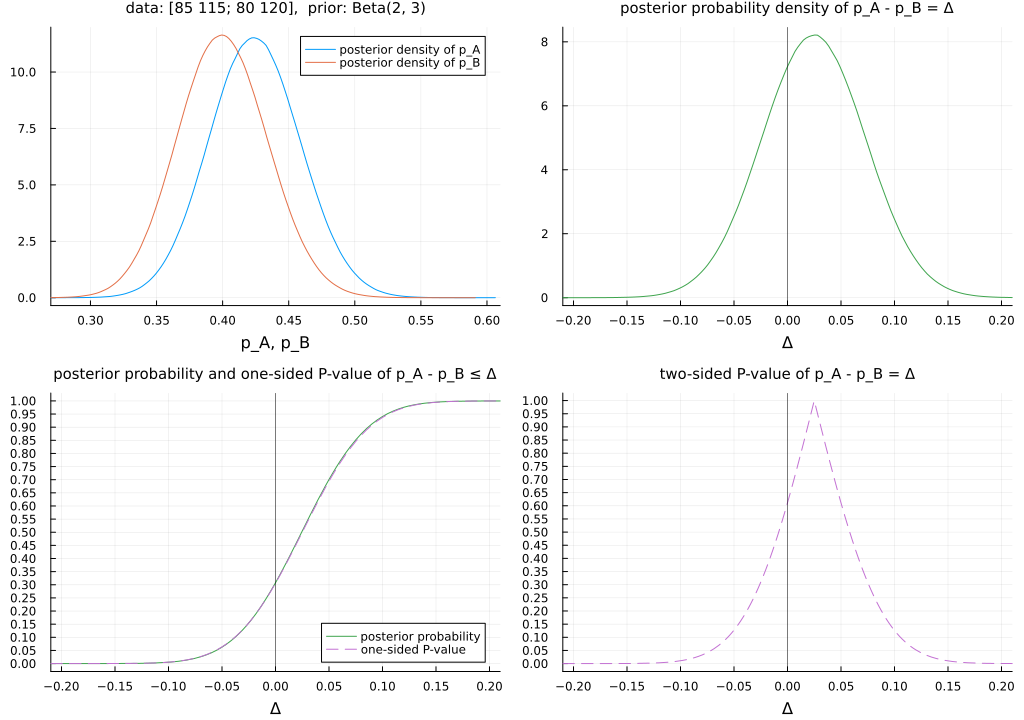

In [9]:
plot_AB_test(85, 115, 80, 120; prior_params=(2, 3),
    plim=(0.27, 0.61), ptick=0:0.05:1, xlim=(-0.21, 0.21), xtick=-1:0.05:1)

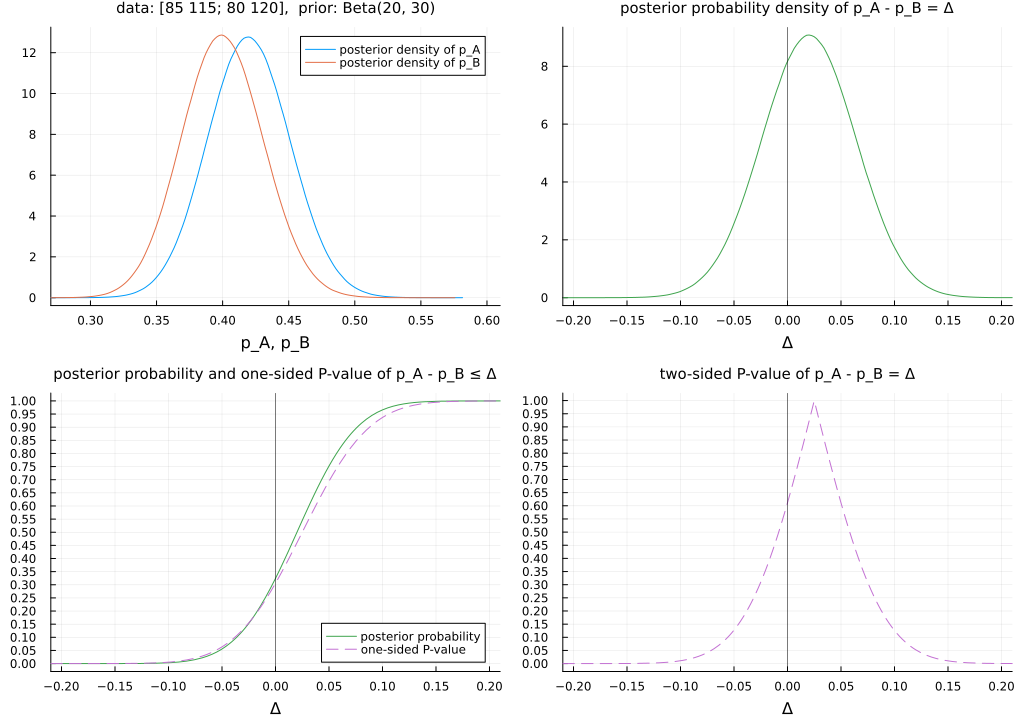

In [10]:
plot_AB_test(85, 115, 80, 120; prior_params=(20, 30),
    plim=(0.27, 0.61), ptick=0:0.05:1, xlim=(-0.21, 0.21), xtick=-1:0.05:1)